In [1]:
from google.colab import files

# Choose the kaggle.json file that you downloaded
uploaded = files.upload()

# Move the uploaded file to the required directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

100% 121M/121M [00:04<00:00, 35.7MB/s]
100% 121M/121M [00:04<00:00, 28.8MB/s]


In [3]:
import zipfile

with zipfile.ZipFile('/content/face-expression-recognition-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')


In [4]:
import shutil

# Replace 'directory_name' with the name of the directory you want to remove
directory_path = '/content/images/images'

# Use shutil.rmtree to remove the directory and its contents
shutil.rmtree(directory_path)


In [ ]:
# import required packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
from keras.models import model_from_json
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from keras.preprocessing.image import load_img


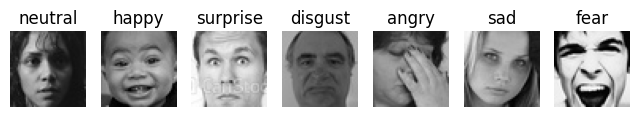

In [48]:
i = 1
plt.figure(figsize=(8, 8))
for expression in os.listdir('/content/images/test/'):
    img = load_img(('/content/images/test/' + expression + '/' +
                    os.listdir('/content/images/test/' + expression)[1]))
    plt.subplot(1, 7, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1

plt.show()

In [10]:
#Check the amount of data in each folder in training dataset
for expression in os.listdir('/content/images/train/'):
    print(expression, "folder contains\t\t",
          len(os.listdir('/content/images/train/' + expression)), "images")

neutral folder contains		 4982 images
happy folder contains		 7164 images
surprise folder contains		 3205 images
disgust folder contains		 436 images
angry folder contains		 3993 images
sad folder contains		 4938 images
fear folder contains		 4103 images


In [11]:
#Check the amount of data in each folder in testing dataset
for expression in os.listdir('/content/images/test/'):
    print(expression, "folder contains\t\t",
          len(os.listdir('/content/images/test/' + expression)), "images")

neutral folder contains		 1216 images
happy folder contains		 1825 images
surprise folder contains		 797 images
disgust folder contains		 111 images
angry folder contains		 960 images
sad folder contains		 1139 images
fear folder contains		 1018 images


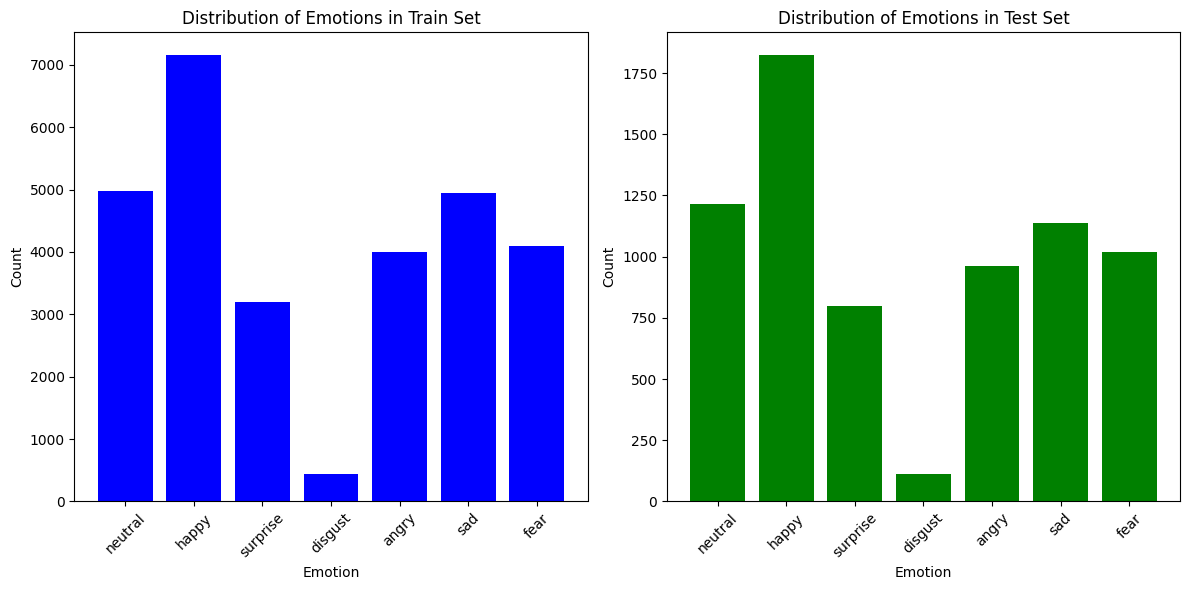

In [43]:
data_dir_train = '/content/images/train'  # Path to train folder
data_dir_test = '/content/images/test'    # Path to test folder

train_emotions = os.listdir(data_dir_train)
test_emotions = os.listdir(data_dir_test)

# Function to count images in each emotion folder
def count_images(data_dir, emotions):
    emotion_count = {}
    for emotion in emotions:
        path = os.path.join(data_dir, emotion)
        if os.path.isdir(path):
            num_images = len(os.listdir(path))
            emotion_count[emotion] = num_images
    return emotion_count

train_emotion_count = count_images(data_dir_train, train_emotions)
test_emotion_count = count_images(data_dir_test, test_emotions)

# Convert counts to DataFrames for easy manipulation and visualization
train_emotion_df = pd.DataFrame(list(train_emotion_count.items()), columns=['Emotion', 'Train_Count'])
test_emotion_df = pd.DataFrame(list(test_emotion_count.items()), columns=['Emotion', 'Test_Count'])

# Plot the distribution of emotions in train and test sets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(train_emotion_df['Emotion'], train_emotion_df['Train_Count'], color='blue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions in Train Set')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(test_emotion_df['Emotion'], test_emotion_df['Test_Count'], color='green')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions in Test Set')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [13]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        '/content/images/train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        '/content/images/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [32]:
# create model structure
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
emotion_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                 

In [33]:
# Train the neural network/model
emotion_model_info = emotion_model.fit(
        train_generator,
        steps_per_epoch=28821 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7066 // 64)


Epoch 1/50
450/450 [==============================] - 21s 41ms/step - loss: 1.7023 - accuracy: 0.3132 - val_loss: 1.4671 - val_accuracy: 0.4263
Epoch 2/50
450/450 [==============================] - 18s 40ms/step - loss: 1.3997 - accuracy: 0.4591 - val_loss: 1.2712 - val_accuracy: 0.5136
Epoch 3/50
450/450 [==============================] - 18s 40ms/step - loss: 1.2632 - accuracy: 0.5175 - val_loss: 1.1891 - val_accuracy: 0.5460
Epoch 4/50
450/450 [==============================] - 18s 41ms/step - loss: 1.1851 - accuracy: 0.5483 - val_loss: 1.1394 - val_accuracy: 0.5683
Epoch 5/50
450/450 [==============================] - 18s 40ms/step - loss: 1.1256 - accuracy: 0.5749 - val_loss: 1.1262 - val_accuracy: 0.5754
Epoch 6/50
450/450 [==============================] - 18s 40ms/step - loss: 1.0762 - accuracy: 0.5943 - val_loss: 1.0813 - val_accuracy: 0.5962
Epoch 7/50
450/450 [==============================] - 18s 40ms/step - loss: 1.0349 - accuracy: 0.6085 - val_loss: 1.0685 - val_accuracy:

In [34]:
# save model structure in json file
model_json = emotion_model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model.h5')

In [35]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [36]:
def ef(image):
    img = load_img(image,grayscale =  True )
    feature = np.array(img)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0


In [50]:
image = '/content/images/test/happy/10074.jpg'
print("original image is of happy")
img = ef(image)
pred = emotion_model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)

original image is of happy
1/1 [==============================] - 0s 33ms/step
model prediction is  happy


Loaded model from disk
Found 7066 images belonging to 7 classes.


<ipython-input-26-767104880ef0>:32: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = emotion_model.predict_generator(test_generator)


-----------------------------------------------------------------
[[141   4 105 265 177 168 100]
 [ 10   0   7  33  24  20  17]
 [151   9 103 272 194 177 112]
 [254  27 200 529 335 286 194]
 [194  17 129 330 196 215 135]
 [182  15 124 311 206 178 123]
 [109  10  89 226 159 126  78]]


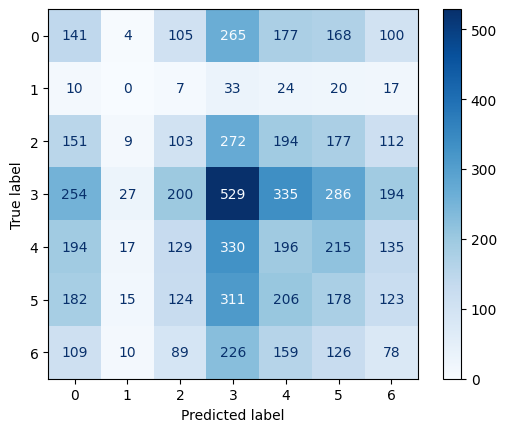

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.14      0.15      0.14       960
           1       0.00      0.00      0.00       111
           2       0.14      0.10      0.12      1018
           3       0.27      0.29      0.28      1825
           4       0.15      0.16      0.16      1216
           5       0.15      0.16      0.15      1139
           6       0.10      0.10      0.10       797

    accuracy                           0.17      7066
   macro avg       0.14      0.14      0.14      7066
weighted avg       0.17      0.17      0.17      7066



In [26]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# load json and create model
json_file = open('/content/emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

# load weights into new model
emotion_model.load_weights("/content/emotion_model.h5")
print("Loaded model from disk")

# Initialize image data generator with rescaling
test_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
test_generator = test_data_gen.flow_from_directory(
        '/content/images/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# do prediction on test data
predictions = emotion_model.predict_generator(test_generator)


print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(test_generator.classes, predictions.argmax(axis=1)))
